In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType

In [2]:
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn import preprocessing

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[9]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

### Load data

In [27]:
totalcounts = spark.read.option('header', False)\
                     .option('lineSep', '\t')\
                     .csv('/data/shared1/total_counts/totalcounts-2')

In [28]:
upperdf = spark.read.format("csv").option("delimiter",";").load("/data/shared1/bigrams/Part1/2-00116-of-00589")

for i in range(0, 500):
    upperdf = upperdf.withColumn('c'+str(i),split("_c0","\t").getItem(i))
    
upperdf = upperdf.drop('_c0')

In [29]:
lowerdf = spark.read.format("csv").option("delimiter",";").load("/data/shared1/bigrams/part2/2-00405-of-00589")

for i in range(0, 500):
    lowerdf = lowerdf.withColumn('c'+str(i),split("_c0","\t").getItem(i))
    
lowerdf = lowerdf.drop('_c0')

### Clean data

In [30]:
totalcounts = totalcounts.withColumnRenamed('_c0', 'year')
totalcounts = totalcounts.withColumnRenamed('_c1', 'ngram_count')
totalcounts = totalcounts.withColumnRenamed('_c2', 'page_count')
totalcounts = totalcounts.withColumnRenamed('_c3', 'volume_count')
totalcounts = totalcounts.withColumn('year', totalcounts['year'].cast('int'))
totalcounts = totalcounts.where(totalcounts['year'] >= 1900)

In [31]:
def to_long(df, by):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("key"), col(c).alias("val")) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + ["kvs.key", "kvs.val"])

In [32]:
upper_long = to_long(upperdf, ["c0"])
upper_long = upper_long.dropna()

lower_long = to_long(lowerdf, ["c0"])
lower_long = lower_long.dropna()

In [33]:
def transform(df):
    split_col = pyspark.sql.functions.split(df['val'], ',')
    df = df.withColumn('year', split_col.getItem(0))
    df = df.withColumn('count', split_col.getItem(1))
    df = df.withColumn('volume', split_col.getItem(2))

    df = df.withColumnRenamed('c0', 'ngram')

    df = df.withColumn('year', df['year'].cast('int'))
    df = df.drop('val')
    df = df.drop('key')
    df = df.where(df['year'] >= 1900)
    
    return df

In [34]:
upperdf = transform(upper_long)
lowerdf = transform(lower_long)

In [35]:
def select_ngram(ngram, df):
    df = df.where((col('ngram') == ngram))
    return df

In [36]:
upperdf = select_ngram('Kitchen_NOUN table_NOUN', upperdf)
lowerdf = select_ngram('first_ADJ use_NOUN', lowerdf)

In [37]:
#upperdf = select_ngram('Cellular_ADJ service_NOUN', upperdf)
#lowerdf = select_ngram('cellular_ADJ service_NOUN', lowerdf)

In [38]:
#upperdf = select_ngram('political_ADJ Islam_NOUN', lowerdf)
#lowerdf = select_ngram('political_ADJ islam_NOUN', lowerdf)

In [39]:
# fill dataset such that each ngram has an entry for each year - fill with 0 if ngram doesn't appear in given year
def all_years(df):
    periods = spark.range(1900, 2019+1).withColumnRenamed("id", "year")
    unique_ngrams = df.select('ngram').distinct()

    periods = unique_ngrams.crossJoin(periods)

    full = periods.join(df, ['year', 'ngram'], how="full")
    full = full.fillna({'count': 0, 'volume': 0 })
    
    return full

In [40]:
upperdf = all_years(upperdf)
lowerdf = all_years(lowerdf)

### Compute stats 

In [41]:
def compute_stats(full):
    # construct dataframe containing all rows and totalcounts
    df = full.join(totalcounts.select('ngram_count', 'volume_count', 'year'), ['year'], how='left')
    df = df.withColumnRenamed('ngram_count', 'total_ngrams')
    df = df.withColumnRenamed('volume_count', 'total_volumes')

    # compute percentages
    df = df.withColumn('ngram_percent', (F.col('count') / F.col('total_ngrams')) * 100)
    df = df.withColumn('volume_percent', (F.col('volume') / F.col('total_volumes')) * 100)

    df = df.drop('total_ngrams')
    df = df.drop('total_volumes')
    return df

In [42]:
upperdf = compute_stats(upperdf)
lowerdf = compute_stats(lowerdf)

### Convert dataframes to use for case correlation

In [17]:
def convert(df):
    df = df.sort(asc('year'))
    
    df = df.drop('year', 'volume', 'volume_percent_smooth', 'volume_percent', 'count', 'ngram_percent_smooth')

    df_pd = df.toPandas()
    
    df_pd = df_pd.drop('ngram', 1)

    return df_pd

In [18]:
lowerdf_pd = convert(lowerdf)
upperdf_pd = convert(upperdf)

KeyboardInterrupt: 

In [131]:
lowerdf_pd = lowerdf_pd.rename(columns={'ngram_percent':'ngram_percent_l'})

upperdf_pd = upperdf_pd.rename(columns={'ngram_percent':'ngram_percent_u'})

In [43]:
def compute_corrdf(lowerdf, upperdf):
    df = pd.concat([lowerdf, upperdf], axis=1)
    return df

In [133]:
df = compute_corrdf(lowerdf_pd, upperdf_pd)

### Compute and plot correlations for upper/lower case

In [134]:
def plot_case_correlation(df, ngramlower, ngramupper, normalize):
    
    if normalize == 1:
        normalized_data = preprocessing.minmax_scale(df)
        df = pd.DataFrame(normalized_data, columns={'ngram_percent_l', 'ngram_percent_u'})
    
    overall_pearson_r = df.corr().iloc[0,1]

    # Compute rolling window synchrony
    f,ax=plt.subplots(figsize=(14,3))
    df.rolling(window=1,center=True).median().plot(ax=ax, style=['-','--'], linewidth=2)
    ax.set(xlabel='Year',ylabel='Normalized percentage')
    ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,3)}");
    ax.legend([ngramlower, ngramupper]) 
    
    labels = ['0', '1900', '1920','1940','1960','1980','2000','2020']
    #labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    
    plt.show()

<ipython-input-134-577e44bafad2>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


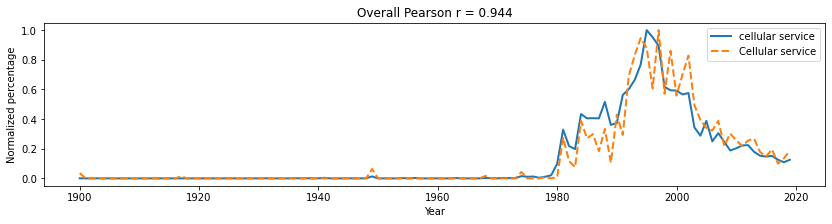

In [135]:
plot_case_correlation(df, 'cellular service', 'Cellular service', normalize=1)

### Compute dataframe to use for count correlation

In [44]:
def convert_volume(df):
    df = df.sort(asc('year'))
    
    df = df.drop('year', 'volume', 'volume_percent_smooth', 'ngram_percent', 'count', 'ngram_percent_smooth')

    df_pd = df.toPandas()
    
    df_pd = df_pd.drop('ngram', 1)

    return df_pd

In [45]:
def convert_count(df):
    df = df.sort(asc('year'))
    
    df = df.drop('year', 'volume', 'volume_percent_smooth', 'volume_percent', 'count', 'ngram_percent_smooth')

    df_pd = df.toPandas()
    
    df_pd = df_pd.drop('ngram', 1)

    return df_pd

In [46]:
volume_pd = convert_volume(lowerdf)
count_pd = convert_count(lowerdf)

In [47]:
df2 = compute_corrdf(volume_pd, count_pd)

### Compute and plot correlations for volume/ngram count

In [48]:
def plot_count_correlation(df, normalize):
    
    if normalize == 1:
        normalized_data = preprocessing.minmax_scale(df)
        df = pd.DataFrame(normalized_data, columns={'ngram_percent', 'volume_percent'})
    
    overall_pearson_r = df.corr().iloc[0,1]

    # Compute rolling window synchrony
    f,ax=plt.subplots(figsize=(14,3))
    df.rolling(window=1,center=True).median().plot(ax=ax, style=['-','--'], linewidth=2)
    ax.set(xlabel='Year',ylabel='Normalized percentage')
    ax.set(title=f"\"first_adj use_noun\", Overall Pearson r = {np.round(overall_pearson_r,3)}");
    ax.legend(['volume percentage', 'ngram percentage']) 
    
    labels = ['0', '1900', '1920','1940','1960','1980','2000','2020']
    ax.set_xticklabels(labels)
    
    plt.show()

<ipython-input-48-35efe6a76e2a>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


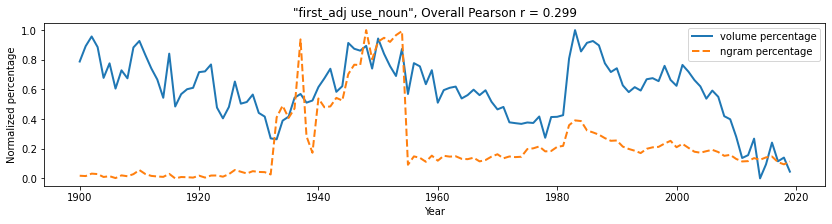

In [49]:
plot_count_correlation(df2, normalize=1)

<ipython-input-140-a40a8ead66cd>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


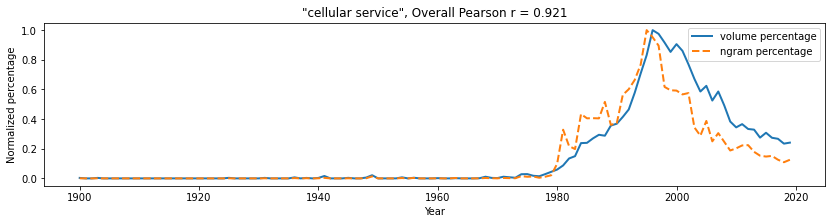

In [141]:
plot_count_correlation(df2, normalize=1)